In [1]:
import os
import sys
import cv2 as cv
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import color, data, exposure, filters, morphology, restoration
from skimage.measure import shannon_entropy
#from scipy.spatial import distance as sc_distance
#from skimage.feature import peak_local_max, canny
from skimage.segmentation import watershed
from sklearn.cluster import KMeans
#import torch
#import torchvision.ops.boxes as bops
src_path = os.path.abspath(os.path.join(os.path.abspath(''), '../'))
sys.path.append(src_path)
import blob_class as bc
import blob_detection as bd
import contrast_functions as cf
import param_output as po

In [2]:
def rescale_image(image, min_pixel=0.35, max_pixel=99.65):
    # Calculate the minimum and maximum pixel intensities for rescaling
    percentile_0 = np.percentile(image, min_pixel)
    percentile_100 = np.percentile(image, max_pixel)

    # Rescale the image
    rescaled_image = np.clip(image, percentile_0, percentile_100)
    rescaled_image = ((rescaled_image - percentile_0) / (percentile_100 - percentile_0)) * 255
    rescaled_image = rescaled_image.astype(np.uint8)

    return rescaled_image

In [3]:
def estimate_noise(image):
    """
    Estimate the noise of an image using the MAD method
    """
    # Convert the image to grayscale if it's RGB
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
        
    # Median filter the image
    med = ndi.median_filter(image, 5)
    
    # Calculate the absolute difference between the original image and the median image
    mad = np.mean(np.abs(image - med))
    
    return mad

def denoise_image(image, threshold):
    """
    De-noise the image using non-local means, altering h parameter until noise is below threshold.
    """
    # Initial h value
    h = 0.1
    # Increment h value
    increment = 0.1

    # Measure the noise
    noise = estimate_noise(image)
    
    # Return the original image if the noise is already less than the threshold
    if noise < threshold:
        return image

    while noise > threshold:
        denoised = restoration.denoise_nl_means(image, h=h, fast_mode=True)
        noise = estimate_noise(denoised)
        h += increment

    return denoised

In [4]:
def enhance_contrast(image, method='histogram_eq'):
    """
    Enhance the contrast of the image.
    Parameters:
    - image : The input image.
    - method: The contrast enhancing method, can be 'histogram_eq', 'adaptive_histogram_eq', 'contrast_stretching', 'log_transform', 'power_law_transform', 'sigmoid_correction', 'clahe'
    Returns:
    - The contrast enhanced image.
    """

    # Convert image to uint8, necessary for some methods
    image = cv.normalize(image, None, 0, 255, cv.NORM_MINMAX, dtype=cv.CV_8U)

    if method == 'histogram_eq':
        return cv.equalizeHist(image)
    elif method == 'adaptive_histogram_eq':
        return exposure.equalize_adapthist(image, clip_limit=0.03)
    elif method == 'contrast_stretching':
        p2, p98 = np.percentile(image, (2, 98))
        return exposure.rescale_intensity(image, in_range=(p2, p98))
    elif method == 'log_transform':
        c = 255 / np.log(1 + np.max(image))
        log_image = c * (np.log(image + 1))
        return np.array(log_image, dtype=np.uint8)
    elif method == 'power_law_transform':
        gamma = 0.5  # Gamma < 1 decreases the influence of high intensity values
        return np.array(255*(image / 255) ** gamma, dtype = 'uint8')
    elif method == 'sigmoid_correction':
        return exposure.adjust_sigmoid(image)
    elif method == 'clahe':
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(image)
    else:
        print("Invalid contrast enhancement method. Choose either 'histogram_eq', 'adaptive_histogram_eq', 'contrast_stretching', 'log_transform', 'power_law_transform', 'sigmoid_correction', or 'clahe'.")
        return image

In [5]:
def crop_nuclei(image, min_percent_area=10):
    """
    Crops the image to a bounding box of the largest contour

    Parameters
    ----------
    image : image matrix
        input image

    min_percent_area : int or float
        Minimum percent of image area to be considered
        an actual contour to crop

    Returns
    -------
    cropped_image: image matrix
        Image cropped to the bounding box of the largest contour
    nuclei_contours: list of contours
        Contours of nuclei found in the image
    """
    
    im = rescale_image(image)
    
    # Convert the image to grayscale if it's not already
    if len(im.shape) == 3 and im.shape[2] == 3:  # Check for 3 channels (RGB)
        im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    else:
        im_gray = im.copy()
    
    #im_blur = denoise_image(im_gray, threshold = 0.005)
    im_blur = cv.GaussianBlur(im_gray,(15,15),0)
    im_blur = rescale_image(im_blur)

    # find edges in the image
    edges = filters.sobel(im_blur)
    edges = cf.percentile_rescale(edges, 0.35, 99.65)

    # make binary image
    #thresh = filters.threshold_li(edges)
    #_ , im_binary = cv.threshold(edges, thresh, 255, cv.THRESH_BINARY)
    thresh = 25
    _ , im_binary = cv.threshold(im_blur, thresh, 255, cv.THRESH_BINARY)
    
    # find and sort contours by area - largest first
    contours, _ = cv.findContours(im_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    
    # find min_area
    shape = im_gray.shape
    ax1 = shape[0] * min_percent_area / 100
    ax2 = shape[1] * min_percent_area / 100
    min_area = ax1 * ax2
    
    # Crop to bounding box of each contour that is above the min_area
    cropped_images = []
    nuclei_contours = []
    for cont in contours:
        if cv.contourArea(cont) > min_area:
            x, y, w, h = cv.boundingRect(cont)
            cropped = im[y:y+h, x:x+w]
            cropped_images.append(cropped)
            
            # Adjust contour to account for the cropping
            adjusted_contour = cont.copy()
            adjusted_contour[:, :, 0] -= x  # adjust x coordinate
            adjusted_contour[:, :, 1] -= y  # adjust y coordinate
            nuclei_contours.append(adjusted_contour)
        else:
            # break as next blob would be smaller
            break

    return cropped_images, nuclei_contours


In [6]:
def maxima_filter(contour, local_maxima):

    if len(local_maxima) == 0:
        return None, None
    # points is list of booleans
    # True in each index that maxima is inside contour
    points = np.array([cv.pointPolygonTest(np.array(contour),
                                           (int(maxima[0]), int(maxima[1])),
                                           False)
                       for maxima in local_maxima])

    if np.sum(points == 1) >= 1:  # if maxima found
        idxs = np.where(points == 1)  # points are true
        maxima = np.array(local_maxima)[idxs]
        return maxima, idxs[0]

    # return None if no maxima found
    return None, None

def get_contours(image, min_length=5, thresh_min=50, thresh_max=255, thresh_step=10, maxima_thresh = 127, thresh_diff_limit=30):
    im = image.copy()
    all_maxima = {}
    all_contours = {}
    all_contours_list = []

    # Step 1: Gather all maxima and contours at different thresholds
    for thresh in range(thresh_max, thresh_min - thresh_diff_limit, -thresh_step):
        _, im_binary = cv.threshold(im, thresh, 255, cv.THRESH_BINARY)
        contours, _ = cv.findContours(im_binary, cv.RETR_CCOMP, cv.CHAIN_APPROX_NONE)
        maxima_at_thresh = []
        contours_at_thresh = []
        for contour in contours:
            if len(contour) >= min_length:
                maxima = tuple(np.mean(contour, axis=0)[0].astype(int))
                maxima_at_thresh.append(maxima)
                contours_at_thresh.append(contour)
                all_contours_list.append(contour)
        all_maxima[thresh] = maxima_at_thresh
        all_contours[thresh] = contours_at_thresh

    # Step 2: Filter maxima based on overlap criteria
    filtered_maxima = []
    for thresh_high in range(thresh_max, max(maxima_thresh, thresh_min), -thresh_step):
        maxima_at_high_thresh = all_maxima[thresh_high]
        maxima_considered = filtered_maxima + maxima_at_high_thresh
        contours_at_low_thresh = all_contours.get(thresh_high - thresh_diff_limit, [])
        for contour_low in contours_at_low_thresh:
            maxima_in_contour_low, idxs = maxima_filter(contour_low, maxima_considered)
            if maxima_in_contour_low is not None:
                if len(maxima_in_contour_low) == 1:
                    filtered_maxima.append(tuple(maxima_in_contour_low[0]))
                else:
                    # check if any of the maxima already in filtered_maxima
                    maxima_in_filtered = any([tuple(maxima_in_contour_low[i]) in filtered_maxima 
                                              for i in range(len(maxima_in_contour_low))])
                    # if no maxima already in filtered_maxima, append first to list (doesn't matter which maxima, just need one)
                    if not maxima_in_filtered:
                        filtered_maxima.append(tuple(maxima_in_contour_low[0]))
                        

    return all_contours_list, filtered_maxima


In [7]:
def organize_contours(contours, coords):
    """
    Should probably change segmentation parameters, segments
    too easily with more maxima
    """
    # sort by area - smallest first
    cnts_area = [cv.contourArea(cnt) for cnt in contours]
    cnts_rank = np.argsort(np.array(cnts_area))
    contours = np.array(contours, dtype=object)[cnts_rank]
    
    # initalize empty list that will hold contours
    contour_list = [[] for pt in coords]

    # initalize list that contains index of points in contour_list
    unique_points = [[i] for i in range(len(coords))]

    # for each original contour found
    for contour in contours:
        maxima, idxs = maxima_filter(contour, coords)
        if idxs is not None:

            # if contour contains one maxima, append to idx in list
            if len(idxs) == 1:
                contour_list[idxs[0]].append(contour)
                            
    return contour_list

In [8]:
def best_contours(contours, edges):
    
    # initalize list for best contours
    best_conts = []

    for i in range(len(contours)):
        if len(contours[i]) == 1:
            best_conts.append(contours[i][0])
            
        elif len(contours[i]) > 1:
            # find means of each contour for each maxima
            mean_list = []
            for cont in contours[i]:
                pts = np.array([[pt[0][1], pt[0][0]] for pt in cont])
                edge_mean = np.mean(edges[tuple(pts.T)])
                mean_list.append(edge_mean)

            # append contour with highest edge_mean to best_conts list
            max_idx = np.argmax(mean_list)
            best_conts.append(contours[i][max_idx])
            
    return best_conts


def best_contours2(org_contours, edges, labeled_blobs, threshold=0.9):
    
    # Initialize list for best contours
    best_conts = []
    
    # For each set of contours associated with a specific maxima/region
    for contour_set in org_contours:
        # If the contour set is empty, continue to next
        if len(contour_set) == 0:
            continue

        # Determine the region by checking the label of the largest contour
        largest_contour = max(contour_set, key=cv.contourArea)
        
        # Create a mask of the largest contour
        mask = np.zeros_like(labeled_blobs, dtype=np.uint8)
        cv.drawContours(mask, [largest_contour], -1, (1,), thickness=cv.FILLED)

        # Extract the regions inside the largest contour
        regions_inside = labeled_blobs * mask
        
        # Find the dominant label inside the largest contour (excluding 0)
        labels, counts = np.unique(regions_inside, return_counts=True)
        if 0 in labels:
            index_of_zero = np.where(labels == 0)[0][0]
            labels = np.delete(labels, index_of_zero)
            counts = np.delete(counts, index_of_zero)
        if len(labels) == 0:  # If only background is present
            continue
        dominant_label = labels[np.argmax(counts)]

        best_score = 0
        best_contour = None
        
        for contour in contour_set:
            mask = np.zeros_like(edges, dtype=np.uint8)
            cv.drawContours(mask, [contour], -1, (1,), thickness=cv.FILLED)
            
            # Calculate area of the contour within the current labeled region
            intersect_area = np.sum(mask & (labeled_blobs == dominant_label))
            
            # Compute the area of the labeled region directly
            label_area = np.sum(labeled_blobs == dominant_label)
            
            # Check if contour covers at least the threshold fraction of the labeled region
            if intersect_area >= threshold * label_area:
                pts = np.array([[pt[0][1], pt[0][0]] for pt in contour])
                edge_mean = np.mean(edges[tuple(pts.T)])
                
                if edge_mean > best_score:
                    best_score = edge_mean
                    best_contour = contour
                    
        if best_contour is not None:
            best_conts.append(best_contour)
        else:
            # If no contour meets the threshold, generate a new contour for the region
            region_mask = (labeled_blobs == dominant_label).astype(np.uint8)
            new_contours, _ = cv.findContours(region_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
            
            if new_contours:
                new_contour = max(new_contours, key=cv.contourArea)
                best_conts.append(new_contour)
    
    return best_conts

In [51]:
def watershed_using_best_contours(image, cnts_best):
    # Reshape image to be 2D (each row corresponds to a pixel, columns are the RGB channels)
    pixels = image.reshape(-1, 1)
    
    # Use K-means clustering with 4 clusters
    kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels)
    clustered_image = kmeans.labels_.reshape(image.shape)
    
    # Calculate cluster means
    cluster_means = kmeans.cluster_centers_.squeeze()
    
    # Get the pixel intensities corresponding to definitely and possibly DNA blobs
    unique_labels = np.unique(clustered_image)
    sorted_labels = unique_labels[np.argsort(cluster_means)]
    dna_blobs_1 = (clustered_image == sorted_labels[-1]).astype(np.uint8) # very likely dna blobs
    dna_blobs_2 = (clustered_image == sorted_labels[-2]).astype(np.uint8) # possibly dna blobs
    
    # Combine both DNA blobs 1 and 2
    possibly_dna_blobs = dna_blobs_1 + dna_blobs_2
    
    # Create an empty mask to store the regions inside the best contours
    sure_fg = np.zeros_like(image, dtype=np.uint8)
    
    # Fill in the contours to create the mask of sure foreground
    cv.drawContours(sure_fg, cnts_best, -1, (1,), thickness=cv.FILLED)

    # The unknown region is the inverse of the sure foreground
    unknown = (possibly_dna_blobs - sure_fg).clip(0, 1)  # Clip to ensure only values 0 or 1
    
    # Marker labelling
    ret, markers = cv.connectedComponents(sure_fg)
    
    # Add one to all the labels so that the background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 1] = 0  
    marker_display = rescale_image(markers)
    #cv.imshow("Watershed Pre", marker_display)
    #cv.waitKey()
    cv.imwrite("im_pres/im_watershed_pre.jpg", marker_display)
    
    # Convert image to BGR for the watershed method
    if len(image.shape) == 2:  # If grayscale, convert to BGR
        image_bgr = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    else:
        image_bgr = image.copy()

    # Perform the watershed and update the markers image
    markers = cv.watershed(image_bgr, markers)

    # (Optional) If you want to view the result
    marker_display = rescale_image(markers)
    #cv.imshow("Watershed Result", marker_display)
    #cv.waitKey()
    cv.imwrite("im_pres/im_watershed_post.jpg", marker_display)
    
    # To store all the marker contours
    marker_contours = []

    # Extract unique marker values
    unique_markers = np.unique(markers)
    unique_markers = unique_markers[unique_markers != -1]  # Exclude -1/boundries
    unique_markers = unique_markers[unique_markers != 1]   # Exclude 1/background
    
    # Iterate through each unique marker value to find its contours
    for marker in unique_markers:
        binary_image = np.where(markers == marker, 255, 0).astype(np.uint8)  # Convert to binary
        contours, _ = cv.findContours(binary_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        marker_contours.extend(contours)
    
    return markers, marker_contours

In [10]:
def smooth_contours(contours, window_size=3):
    """
    Smooth contours using a moving average technique.

    Parameters:
    - contours: list of contours to be smoothed.
    - window_size: size of the moving average window.

    Returns:
    - smoothed_contours: list of smoothed contours.
    """

    smoothed_contours = []

    for contour in contours:
        # Convert contour to a numpy array for easier slicing and computations
        contour = np.squeeze(contour)
        
        # Safeguard: Ensure the window size is not above 10% of the contour length
        max_window_size = int(0.1 * len(contour))
        if window_size > max_window_size:
            window_size = max_window_size

        # Calculate the number of points to prepend and append
        extend_size = (window_size - 1) // 2

        # Append and prepend the last and first points to handle boundary conditions
        extended_contour = np.vstack([contour[-extend_size:], contour, contour[:extend_size]])

        # Apply moving average
        smoothed_x = np.convolve(extended_contour[:, 0], np.ones(window_size)/window_size, mode='valid')
        smoothed_y = np.convolve(extended_contour[:, 1], np.ones(window_size)/window_size, mode='valid')

        # Stack the smoothed coordinates
        smoothed = np.stack([smoothed_x, smoothed_y], axis=1).astype(np.int32)

        smoothed_contours.append(smoothed.reshape(-1, 1, 2))

    return smoothed_contours

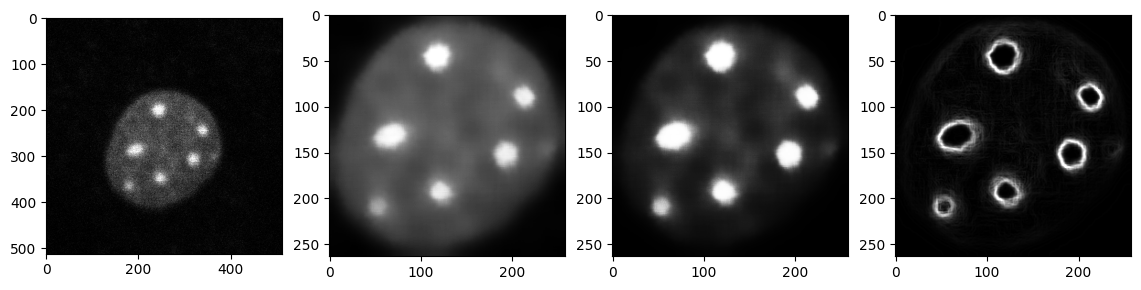

In [32]:
### May need to include nucleus as blob - find contour from im_blur
### nuc_blob = bc.Blob(nuc_blur.cv_contour, nuc_fill)
### Maybe need to sharpen blurred image

im = cv.imread('../example_images/ex3.tif')
#im = rescale_image(im)
ims, nuc_cnts = crop_nuclei(im) # get first/largest cropped nuclei
im_crop = ims[0]
im_gray = cv.cvtColor(im_crop, cv.COLOR_BGR2GRAY)
im_blur = denoise_image(im_gray, threshold = 0.005) #typically 0.005
im_blur = rescale_image(im_blur)
# maybe remove im_cont?
im_cont = enhance_contrast(im_blur, method='sigmoid_correction')
edges = filters.sobel(im_cont) # typically im_cont but im_blur may be better
edges = rescale_image(edges)
    
fig = plt.figure(figsize = (14,5))
fig.add_subplot(1, 4, 1)
plt.imshow(im, cmap = "gray")
fig.add_subplot(1, 4, 2)
plt.imshow(im_blur, cmap = "gray")
fig.add_subplot(1, 4, 3)
plt.imshow(im_cont, cmap='gray')
fig.add_subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')

C:\Users\Kurti\anaconda3\envs\aqua\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


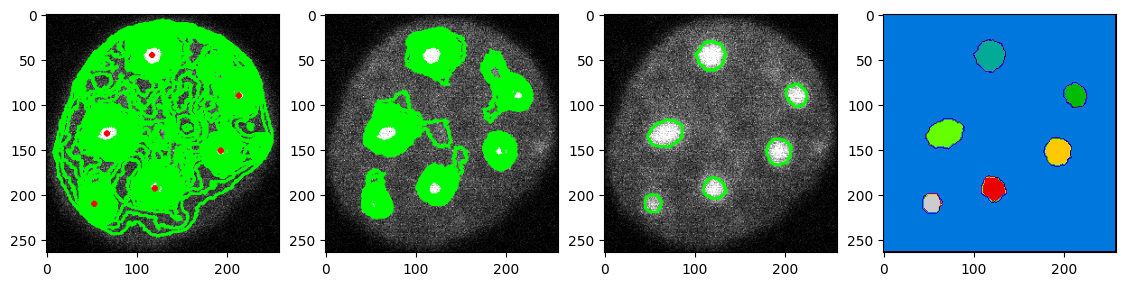

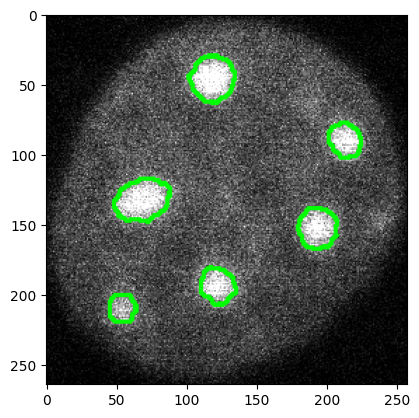

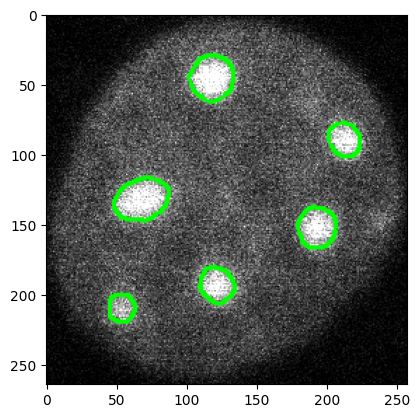

In [53]:
contours, maxima = get_contours(im_cont, min_length=10, thresh_min=50, thresh_step=5, maxima_thresh=100, thresh_diff_limit=40)
contours2 = contours.copy() # for making images
org_contours = organize_contours(contours, maxima)

cnts_best = best_contours(org_contours, edges)

markers, marker_cnts = watershed_using_best_contours(im_blur, cnts_best) #im_blur might be more sufficient here

smoothed_cnts = smooth_contours(marker_cnts, 7)

cont_im = im_crop.copy()
cv.drawContours(cont_im, contours, -1, (0,255,0), 2)
for coordinate in maxima:
    cv.circle(cont_im, (coordinate), 2, (255,0,0), 2)
#cv.imwrite("ex_all_cnts_maxima.jpg", cont_im) 

cont_im4 = im_crop.copy()
for contours in org_contours:
    cv.drawContours(cont_im4, contours, -1, (0,255,0), 2)
#cv.imwrite("ex_all_seg_cnts.jpg", cont_im4) 

cont_im2 = im_crop.copy()
cv.drawContours(cont_im2, cnts_best, -1, (0,255,0), 2)
#cv.imwrite("ex_best_cnts.jpg", cont_im2) 
cont_im3 = im_crop.copy()
cv.drawContours(cont_im3, marker_cnts, -1, (0,255,0), 2)
#cv.imwrite("expansion3_bad_maxima_final_cnts.jpg", cont_im3) 

cont_im5 = im_crop.copy()
cv.drawContours(cont_im5, smoothed_cnts, -1, (0,255,0), 2)
#cv.imwrite("expansion3_bad_maxima_final_cnts.jpg", cont_im3) 

fig = plt.figure(figsize = (21,7))
fig.add_subplot(1, 6, 1)
plt.imshow(cont_im, cmap = "gray")
fig.add_subplot(1, 6, 2)
plt.imshow(cont_im4, cmap = "gray")
fig.add_subplot(1, 6, 3)
plt.imshow(cont_im2, cmap = "gray")
fig.add_subplot(1, 6, 4)
plt.imshow(markers, cmap = 'nipy_spectral')
plt.show()
fig.add_subplot(1, 6, 5)
plt.imshow(cont_im3, cmap = 'nipy_spectral')
plt.show()
fig.add_subplot(1, 6, 6)
plt.imshow(cont_im5, cmap = 'gray')
plt.show()

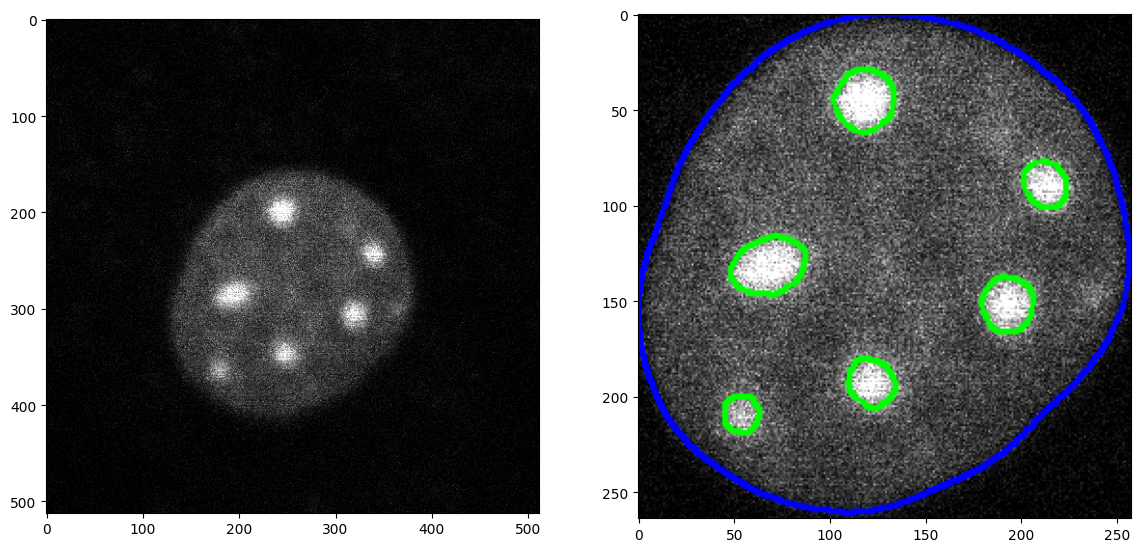

In [34]:
blobs_final = [bc.Blob(cnt, im_cont) for cnt in smoothed_cnts]
nuc_window = round(0.05*len(nuc_cnts[0]))
nuc_smooth = smooth_contours([nuc_cnts[0]], nuc_window)
nuc_blob = bc.Blob(nuc_smooth[0], im_cont)


# get parameters of final blobs
params = po.get_params(blobs_final, nucleus=nuc_blob)
params.to_csv("blob_params.csv")

im_final_cnts = im_crop.copy()
cv.drawContours(im_final_cnts, smoothed_cnts, -1, (0,255,0), 2)
cv.drawContours(im_final_cnts, nuc_smooth, -1, (0,0,255), 2)

fig = plt.figure(figsize = (14,7))
fig.add_subplot(1, 2, 1)
plt.imshow(im, cmap = "gray")
fig.add_subplot(1, 2, 2)
plt.imshow(im_final_cnts, cmap = "gray")

In [37]:
### For saving/generating images only ###

cv.imwrite("im_pres/im.jpg", im)
cv.imwrite("im_pres/im_crop.jpg", im_crop)
cv.imwrite("im_pres/im_blur.jpg", im_blur)
cv.imwrite("im_pres/im_cont.jpg", im_cont)

im_maxima = im_crop.copy()
for coordinate in maxima:
    cv.circle(im_maxima, (coordinate), 2, (0,0,255), 2)
cv.imwrite("im_pres/im_maxima.jpg", im_maxima)

im_all_contours = im_crop.copy()
cv.drawContours(im_all_contours, contours2, -1, (0,255,0), 2)
cv.imwrite("im_pres/im_all_contours.jpg", im_all_contours)

im_maxima_contours = im_crop.copy()
for contours in org_contours:
    cv.drawContours(im_maxima_contours, contours, -1, (0,255,0), 2)
cv.imwrite("im_pres/im_maxima_contours.jpg", im_maxima_contours)

im_best_contours = im_crop.copy()
cv.drawContours(im_best_contours, cnts_best, -1, (0,255,0), 2)
cv.imwrite("im_pres/im_best_contours.jpg", im_best_contours)

im_marker_contours = im_crop.copy()
cv.drawContours(im_marker_contours, marker_cnts, -1, (0,255,0), 2)
cv.imwrite("im_pres/im_marker_contours.jpg", im_marker_contours)

im_smoothed_contours = im_crop.copy()
cv.drawContours(im_smoothed_contours, smoothed_cnts, -1, (0,255,0), 2)
cv.imwrite("im_pres/im_smoothed_contours.jpg", im_smoothed_contours)

im_final_contours = im_crop.copy()
cv.drawContours(im_final_contours, smoothed_cnts, -1, (0,255,0), 2)
cv.drawContours(im_final_contours, nuc_smooth, -1, (255,0,0), 2)
cv.imwrite("im_pres/im_final_contours.jpg", im_final_contours)

True

In [45]:
### Save binary images ###
binary_val = 40
_, im_binary = cv.threshold(im_cont, binary_val, 255, cv.THRESH_BINARY)
cv.imwrite("im_pres/im_binary_" + str(binary_val) + ".jpg", im_binary)

True

In [ ]:
### save pre/post ###
cv.imwrite("im_pres/im2.jpg", im)
cv.imwrite("im_pres/im_crop2.jpg", im_crop)

im_final_contours = im.copy()
cv.drawContours(im_final_contours, smoothed_cnts, -1, (0,255,0), 2)
cv.drawContours(im_final_contours, nuc_smooth, -1, (0,0,255), 2)
cv.imwrite("im_pres/im_final_contours2.jpg", im_final_contours)
